<a href="https://colab.research.google.com/github/Artmalik92/Congruence-Test-For-Students/blob/main/geometry_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В системах геодезического мониторинга одним из методов обнаружения деформаций является построение ГНСС сетей и анализ движений в них при помощи вычисления невязок в замкнутых фигурах или геометрической модели. Геометрическая модель использует геометрические свойства объектов. Например, можно использовать геометрические связи между точками (углы и расстояния) для определения их относительного положения и оценки стабильности измерений. Данный принцип можно реализовать в виде программы геометрического теста на Python.

Геометрический тест стабильности позволяет выявлять аномальные движения в замкнутой геодезической сети путем вычисления разностей параметров этой сети (внутренних углов, длин базовых линий или координат) на начальную и i-ую эпоху. После этого производится статистическая оценка разностей. Если сумма разностей между параметрами статистически не значима, то эти две фигуры конгруэнтны, т. е. аномальных движений нет.

Библиотеки, которые нам понадобятся:

In [ ]:
import pandas
import numpy
from scipy.stats import chi2

Библиотека **pandas** необходима для обработки и структурирования данных в виде таблиц.
**Numpy** используется для выполнения математических операций с матрицами и другими массивами. **Scipy** содержит модуль **stats**, который позволяет выполнять в Python статистические операции, в частности тест Хи-квадрат, который мы будем использовать.

Для начала подготовим тестовый временной ряд координат, на котором будем испытывать код программы:

In [ ]:
''' Исходные данные '''
noise = 0.005           # Амплитуда шума в измерениях
offset = 0.02           # Амплитуда смещения координаты
observations = 50       # количество измерений
start_coordinate = 100  # начальное значение координат

<Axes: >

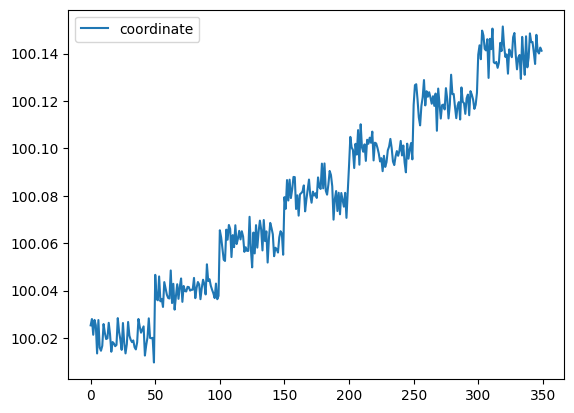

In [ ]:
# сгенерируем несколько сегментов временного ряда с разным значением координаты
segment_1 = numpy.full(observations, start_coordinate + offset)
segment_2 = numpy.full(observations, start_coordinate + offset*2)
segment_3 = numpy.full(observations, start_coordinate + offset*3)
segment_4 = numpy.full(observations, start_coordinate + offset*4)
segment_5 = numpy.full(observations, start_coordinate + offset*5)
segment_6 = numpy.full(observations, start_coordinate + offset*6)
segment_7 = numpy.full(observations, start_coordinate + offset*7)

# объединяем сегменты в один массив
Coordinate = numpy.hstack([segment_1, segment_2, segment_3,
                           segment_4, segment_5, segment_6,
                           segment_7])

# добавляем шум в измерения в виде случайного числа с разбросом 0.005
Coordinate += numpy.random.normal(0, noise, observations*7)

# преобразуем в таблицу DataFrame для дальнейшего использования
df = pandas.DataFrame({'coordinate': Coordinate})

# выводим график на экран
df.plot()

In [ ]:
def geometric_chi_test_calc(time_series_frag,
                          sigma = None,
                          sigma_0 = None,
                          covariances = None) -> tuple:

  # Initialize L array
  L = time_series_frag['coordinate'].values

  # Number of observations
  n = len(L)

  # Create time index
  t = numpy.arange(n)

  # Construct the coefficient matrix A
  A = numpy.vstack((t, numpy.ones(n))).T  # A 2D array with time and a constant term

  # Initialize Q matrix
  Q_size = n
  Q = numpy.zeros((Q_size, Q_size))

  N = A.T @ numpy.linalg.inv(P) @ A
  X = numpy.linalg.inv(N) @ (A.T @ numpy.linalg.inv(P) @ L)

  # Calculate least squares estimates
  x_LS = numpy.array([X[0] * t[-1] + X[1]])  # Last estimate
  x_LS_first = X[0] * t[0] + X[1]  # First estimate

  # Calculate residuals
  V = A @ X - L

  # Calculate mu (root mean square of residuals)
  mu = numpy.sqrt(V.T @ numpy.linalg.inv(P) @ V / (V.shape[0] - 2))

  # Calculate covariance matrix of the parameters
  Qx = numpy.linalg.inv(N)
  C = numpy.array([[t[-1], 1]])  # Transformation matrix for Qv
  Qv = C @ Qx @ C.T

  return x_LS_first, x_LS, Qv, mu, Qx